Import libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
from metrics import print_evaluation_metrics

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()

Train test split

In [3]:
train = df.iloc[:-30]
test = df.iloc[-30:]

Parameter tuning for order and seasonal order

In [4]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25938.670, Time=10.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26938.672, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=26423.839, Time=0.97 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=26020.964, Time=2.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26936.672, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25907.176, Time=5.20 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=25842.497, Time=1.91 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=25934.312, Time=8.12 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=25888.229, Time=1.72 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=26029.229, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=25790.349, Time=2.48 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=25786.897, Time=10.09 sec
 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=26277.875, Time=12.46 sec
 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=25892.708, Time=6.81 sec
 A

Create Model

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train[target_column], order=best_order, seasonal_order=best_seasonal_order
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17487D+01    |proj g|=  3.79108D+00

At iterate    5    f=  9.64420D+00    |proj g|=  4.21047D-01

At iterate   10    f=  9.38562D+00    |proj g|=  4.17948D-01

At iterate   15    f=  9.30051D+00    |proj g|=  1.09491D-01

At iterate   20    f=  9.28727D+00    |proj g|=  1.58048D-02

At iterate   25    f=  9.28704D+00    |proj g|=  1.35368D-03

At iterate   30    f=  9.28694D+00    |proj g|=  1.32646D-02

At iterate   35    f=  9.27563D+00    |proj g|=  7.96180D-02

At iterate   40    f=  9.02167D+00    |proj g|=  1.46723D-01

At iterate   45    f=  8.98391D+00    |proj g|=  1.10471D-02

At iterate   50    f=  8.98346D+00    |proj g|=  1.50996D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           New_deaths   No. Observations:                 1390
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 12)   Log Likelihood              -12487.012
Date:                              Sun, 10 Dec 2023   AIC                          24992.023
Time:                                      10:52:45   BIC                          25039.150
Sample:                                           0   HQIC                         25009.647
                                             - 1390                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8788      0.024    -37.300      0.000      -0.925      -0.833
ar.L2         -0.0390      0.033     -1.175      0.240      -0.104       0.026
ar.L3         -0.3249      0.030    -10.885      0.000      -0.383      -0.266
ar.L4         -0.6880      0.023    -30.373      0.000      -0.732      -0.644
ma.L1          0.0707      0.022      3.234      0.001       0.028       0.114
ma.L2         -0.4970      0.025    -20.039      0.000      -0.546      -0.448
ar.S.L12      -0.5843      0.037    -15.658      0.000      -0.657      -0.511
ma.S.L12      -0.1550      0.040     -3.853      0.000      -0.234      -0.076
sigma2      3.711e+06   6.87e+04     54.025      0.000    3.58e+06    3.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2970.85
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

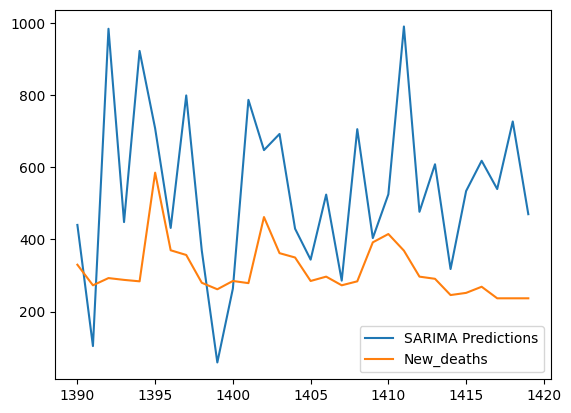

In [6]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels").rename("SARIMA Predictions")
pred.plot(legend=True)
test[target_column].plot(legend=True)

RMSE of the result

In [7]:
print_evaluation_metrics(pred, test[target_column])

Evaluation Metrics:
MSE: 99210.04
RMSE: 314.98
MAE: 249.92
MAPE: 84.87
SMAPE: 55.98
